<a href="https://colab.research.google.com/github/diankaryoko/Satria-Data/blob/main/Big_Data_Challenge_Satria_Data_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Permasalahan**

Berfoto merupakan kegiatan yang biasa terjadi pada setiap manusia, baik dilakukan perorangan ataupun dalam grup. Hasil foto kadang disimpan dan disebarluaskan melalui media-media sosial, seperti: facebook, instagram, dan lain-lain. Selain digunakan untuk kenangan, foto dapat juga digunakan untuk keperluan lain. Pada lomba Big Data Challenge (BDC) Satria Data 2021, peserta ditantang untuk menebak informasi jenis kelamin dan usia individu dari beberapa foto yang diberikan. Proses dalam menebak jenis kelamin dan usia dari foto ini dilakukan dengan menggunakan algoritma dan metode-metode sains data, serta tidak dilakukan secara manual.

Foto yang digunakan dalam lomba BDC 2021 ini adalah foto yang berasal dari ruang publik internet terdiri dari 3 foto untuk setiap individu. Satu foto dapat merupakan foto individu orang tersebut, atau juga foto bersama. Jika dalam satu foto terdapat lebih dari satu orang, maka informasi yang ditebak adalah orang pada foto tersebut yang merupakan orang yang sama dengan referensi foto pada folder yang sama. Selain itu, foto yang diberikan dapat juga bukan foto orang/manusia tapi barang milik orang tersebut (pada data latih). 

# **Dataset**

Data yang digunakan pada kompetisi BDC ini tersedia pada https://ipb.link/data-bdc-2021 yang terdiri atas dua folder yaitu Training dan Testing dan dua file berbentuk csv yaitu train.csv dan submission.csv.  Penjelasan dari masing-masing adalah sebagai berikut.

**Folder Training**

Data training yang digunakan berasal dari ruang publik internet. Pada folder Training diberikan 770 folder yang masing-masing folder berisi tiga file gambar dengan format PNG.

**Folder Testing**

Pada folder Testing diberikan 990 file gambar dengan format PNG.

**File train.csv**

File ini berisi kolom-kolom dengan penjelasan sebagai berikut:
*   Nomor	:	nama folder yang ada di dalam folder Training
*   Jenis kelamin	:	berisi nilai 0 dan 1, dengan kode 1 menyatakan Laki-laki/*   Pria  dan 0 menyatakan Perempuan/Wanita
*   Usia	:	berisi usia seseorang 

File ini memiliki jumlah baris sebanyak 770 baris.

**File submission.csv**

File ini berisi satu kolom yaitu id. Kolom ini berikut nama file gambar yang ada di dalam folder Testing. File ini digunakan untuk dijadikan sebagai template submit hasil prediksi ke web dengan menambah satu kolom yaitu jenis kelamin (harus dalam bentuk 0 dan 1) untuk Babak penyisihan atau usia untuk Babak Semifinal,

**Evaluasi dan Format Submission**

Selanjutnya, model terbaik yang menurut Anda mampu memprediksi jenis kelamin dan usia  tersebut harus Anda implementasikan untuk memprediksi sebanyak 990 foto yang ada pada folder Testing.  Pada babak penyisihan, hanya dievaluasi jenis kelamin saja, sedangkan usia akan dievaluasi untuk tim yang masuk ke semi final. Simpanlah hasil prediksi model Anda terhadap 990 foto tersebut dalam submission.csv. Format hasil prediksi model anda yang ada dalam file submission.csv sesuai dengan yang ada di keterangan sebelumnya. 

Pada babak penyisihan, hasil prediksi peserta akan dinilai menggunakan metric F1-score (https://en.wikipedia.org/wiki/F1_score). Pada semi final, dilakukan proses yang sama hanya prediksi yang dilakukan adalah prediksi usia. Jawaban peserta akan dievaluasi dengan menggunakan Mean Square Error (MSE)(https://en.wikipedia.org/wiki/Mean_squared_error).

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import shutil
import platform
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.12
Tensorflow version: 2.6.0
Keras version: 2.6.0


In [ ]:
# Mengimport data dari google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Membaca file csv train

import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/Data/train.csv')
train.head()

,nomor,jenis kelamin,usia
0,1,0,27
1,2,1,24
2,3,0,29
3,4,1,23
4,5,0,20


In [ ]:
# Membaca file csv submission

submission = pd.read_csv('/content/drive/MyDrive/Data/submission.csv')
submission.head()

,id
0,005093b2-8c4b-4ed7-91c3-f5f4d50f8d27
1,0052554e-069e-4c43-beb0-0885e8f7684e
2,0092b954-1143-4a95-a17b-1edfa6af3b01
3,009fc28b-fe9b-441d-b8a2-ea8b7ae6ca16
4,00d0e306-06fe-45d8-ae6c-6f83ab8f7810


In [ ]:
# Memeriksa jumlah data di folder Training

file_count = sum(len(files) for _, _, files in os.walk('/content/drive/MyDrive/Data/Training'))
print(file_count)

2311


Terdapat 770 folder dengan masing-masing 3 foto di dalamnya, sehingga total file pada data training seharusnya 770 x 3 = 2310. Namun setelah dihitung, ternyata total file yang terdapat pada data training adalah 2311. Ini berarti ada satu folder yang memiliki 4 foto.

In [ ]:
# Memeriksa folder yang memiliki 4 foto

for path, dirnames, files in os.walk('/content/drive/MyDrive/Data/Training'):
  if len(files) == 4:
    print(path, 'memiliki 4 foto')
  else:
    continue

/content/drive/MyDrive/Data/Training/520 memiliki 4 foto


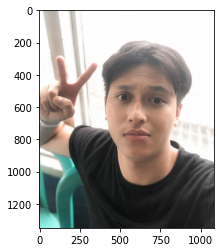

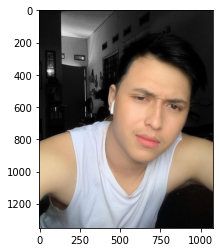

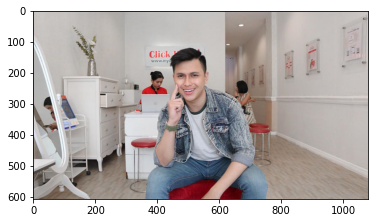

<Figure size 432x288 with 0 Axes>

In [ ]:
# Melihat file image di folder 520

from PIL import Image
import os.path

valid_images = ['.jpg', '.gif', '.png', '.tga']

def show_images(directory):
  for filename in os.listdir(directory):
    ext = os.path.splitext(filename)[1]
    if ext.lower() in valid_images:
      path = directory + '/' + filename
      im = Image.open(path)
      plt.imshow(im)
      plt.show()
      plt.clf() #will make the plot window empty
      im.close()
    else:
      continue

show_images('/content/drive/MyDrive/Data/Training/520')

In [ ]:
os.listdir('/content/drive/MyDrive/Data/Training/520')

['520_1.jpg', '520_3.jpg', 'desktop.ini', '520_2.jpg']

File yang bernama 'desktop.ini' bukan gambar.

In [ ]:
# Memeriksa jumlah data di folder Testing

len(os.listdir('/content/drive/MyDrive/Data/Testing'))

990

In [ ]:
# Membuat directory baru bernama train

train_dir = os.path.join('/content','train')
if not os.path.exists(train_dir):
  os.makedirs(train_dir, exist_ok=True)

# Membuat directory baru bernama female dan male di dalam train_dir

train_female = os.path.join(train_dir, 'female')
if not os.path.exists(train_female):
  os.mkdir(train_female)

train_male = os.path.join(train_dir, 'male')
if not os.path.exists(train_male):
  os.mkdir(train_male)

In [ ]:
# Memisahkan data training ke train_male dan train_female
!pip install autocrop --upgrade --user
from autocrop import Cropper

data_dir = '/content/drive/MyDrive/Data/Training'
cropper = Cropper(face_percent=75, width = 256, height = 256)
for folder in range(1, 771):
  print(folder)
  classnum = int(train[train['nomor'] == folder]['jenis kelamin'])
  path = os.path.join(data_dir, str(folder))
  for img in os.listdir(path):
    if classnum == 0:
      shutil.copyfile(os.path.join(path, img), os.path.join(train_female, img))
      try:
        impath = train_female + '/' + img
        cropped_array = cropper.crop(impath)
        cropped_image = Image.fromarray(cropped_array)
        cropped_image.save(impath)
      except:
        pass
    else:
      shutil.copyfile(os.path.join(path, img), os.path.join(train_male, img))
      try:
        impath = train_male + '/' + img
        cropped_array = cropper.crop(impath)
        cropped_image = Image.fromarray(cropped_array)
        cropped_image.save(impath)
      except:
        pass

ModuleNotFoundError: ignored

In [ ]:
# Memeriksa banyaknya gambar di train_female

len(os.listdir(train_female))

1341

In [ ]:
# Memeriksa banyaknya gambar di train_male

len(os.listdir(train_male))

970

In [ ]:
# Membuang file dengan nama 'dekstop.ini' pada train_male

os.remove('/content/train/male/desktop.ini')

In [ ]:
# Memeriksa banyaknya gambar di train_male

len(os.listdir(train_male))

969

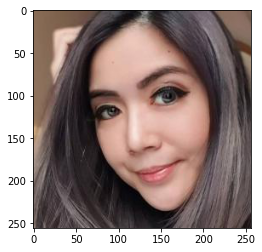

<Figure size 432x288 with 0 Axes>

In [ ]:
# Mendisplay file dari folder train_female

im = Image.open('/content/train/female/102_1.jpg')
plt.imshow(im)
plt.show()
plt.clf()
im.close()

#n = 519*3-3
#plt.figure(figsize = (5,5))
#plt.imshow(df_training[n][0])
#plt.title(df_training[n][1])

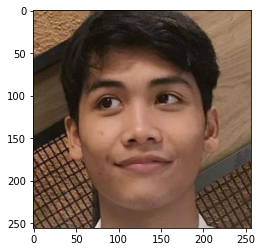

<Figure size 432x288 with 0 Axes>

In [ ]:
# Mendisplay file dari folder train_female

im = Image.open('/content/train/male/209_1.jpg')
plt.imshow(im)
plt.show()
plt.clf()
im.close()

In [ ]:
# Membagi data pada df_training menjadi train dan validation

female_train, female_val = train_test_split(os.listdir(train_female), test_size = 0.2)
male_train, male_val = train_test_split(os.listdir(train_male), test_size = 0.2)

In [ ]:
# Membuat directory baru bernama val

val_dir = os.path.join('/content','val')
if not os.path.exists(val_dir):
  os.makedirs(val_dir, exist_ok=True)

# Membuat directory baru bernama female dan male di dalam val_dir

val_female = os.path.join(val_dir, 'female')
if not os.path.exists(val_female):
  os.mkdir(val_female)

val_male = os.path.join(val_dir, 'male')
if not os.path.exists(val_male):
  os.mkdir(val_male)

In [ ]:
# Memindahkan data validation ke directory val

for i in female_val:
  shutil.move(os.path.join('/content/train/female', i), os.path.join('/content/val/female', i))
for i in male_val:
  shutil.move(os.path.join('/content/train/male', i), os.path.join('/content/val/male', i))

In [ ]:
# Memeriksa banyak data di masing-masing directory

data = [['Female', len(os.listdir(train_female)), len(os.listdir(val_female))],
      ['Male', len(os.listdir(train_male)), len(os.listdir(val_male))],
      ]

df = pd.DataFrame(data, columns=['Label', 'Train Set', 'Validation Set'])
print(df)

    Label  Train Set  Validation Set
0  Female       1072             491
1    Male        775             355


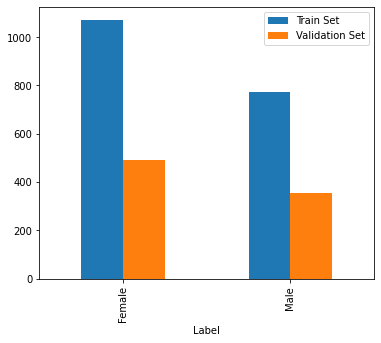

In [ ]:
df.plot(x = 'Label', y = ['Train Set', 'Validation Set'], kind = "bar", figsize = (6,5))
plt.show()

In [ ]:
# Image Data Augmentation

train_datagen = ImageDataGenerator(
        #featurewise_center = False,  # set input mean to 0 over the dataset
        #samplewise_center = False,  # set each sample mean to 0
        #featurewise_std_normalization = False,  # divide inputs by std of the dataset
        #samplewise_std_normalization = False,  # divide each input by its std
        #zca_whitening = False,  # apply ZCA whitening
        rescale = 1./255, # transform every pixel value from range [0,255] -> [0,1]
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        #width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
        #height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
        #horizontal_flip = True,  # randomly flip images
        shear_range = 0.2) # distorted images along axis
        #fill_mode = 'nearest', # to fill the empty area
        #vertical_flip = False)  # randomly flip images

val_datagen = ImageDataGenerator(
        #featurewise_center = False,  # set input mean to 0 over the dataset
        #samplewise_center = False,  # set each sample mean to 0
        #featurewise_std_normalization = False,  # divide inputs by std of the dataset
        #samplewise_std_normalization = False,  # divide each input by its std
        #zca_whitening = False,  # apply ZCA whitening
        rescale = 1./255) # transform every pixel value from range [0,255] -> [0,1]
        #rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        #zoom_range = 0.2, # Randomly zoom image 
        #width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
        #height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
        #horizontal_flip = True,  # randomly flip images
        #shear_range = 0.2) # distorted images along axis
        #fill_mode = 'nearest', # to fill the empty area
        #vertical_flip = False)  # randomly flip images

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'binary'
)

Found 1847 images belonging to 2 classes.
Found 846 images belonging to 2 classes.


In [ ]:
# Membangun model

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

#Melihat ringkasan model

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 128)       7

In [ ]:
# Menambahkan callback

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95 and logs.get('val_accuracy')>0.95):
      print('\nAkurasi telat mencapai 95%!')
      self.model.stop_training = True
callbacks = myCallback()

# Compile model dengan 'adam' optimizer dan loss function 'BinaryCrossentropy'

model.compile(
  optimizer=tf.optimizers.RMSprop(),
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy'])

In [ ]:
# Melatih model dengan model.fit 

epoch = 50
history = model.fit(train_generator, epochs = epoch, validation_data = val_generator, callbacks = [callbacks])

Epoch 1/50
58/58 [==============================] - 68s 1s/step - loss: 0.7984 - accuracy: 0.5793 - val_loss: 0.6475 - val_accuracy: 0.6678
Epoch 2/50
58/58 [==============================] - 67s 1s/step - loss: 0.6188 - accuracy: 0.6551 - val_loss: 0.5494 - val_accuracy: 0.7092
Epoch 3/50
58/58 [==============================] - 67s 1s/step - loss: 0.5950 - accuracy: 0.6789 - val_loss: 0.5657 - val_accuracy: 0.7234
Epoch 4/50
58/58 [==============================] - 67s 1s/step - loss: 0.5579 - accuracy: 0.7109 - val_loss: 0.6025 - val_accuracy: 0.7210
Epoch 5/50
58/58 [==============================] - 66s 1s/step - loss: 0.5422 - accuracy: 0.7233 - val_loss: 0.5058 - val_accuracy: 0.7340
Epoch 6/50
58/58 [==============================] - 66s 1s/step - loss: 0.5132 - accuracy: 0.7423 - val_loss: 0.4481 - val_accuracy: 0.7813
Epoch 7/50
58/58 [==============================] - 66s 1s/step - loss: 0.4885 - accuracy: 0.7558 - val_loss: 0.4385 - val_accuracy: 0.7624
Epoch 8/50
58/58 [==

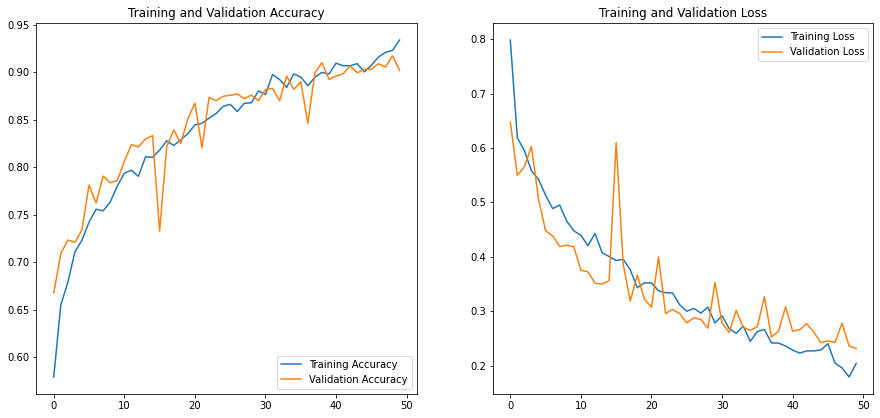

In [ ]:
# Membuat plot akurasi dan loss dari model

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Note: model overfit

In [ ]:
# Menampilkan report dari prediction model

#predictions = model.predict(train_generator)
#predictions = np.argmax(predictions,axis=1)
#predictions = predictions.reshape(1,-1)[0]
#print(classification_report(val_generator, predictions, target_names = ['Female (Class 0)','Male (Class 1)']))

Saving Dian Karyoko.jpg to Dian Karyoko.jpg
Dian Karyoko.jpg
Orang ini berjenis kelamin perempuan


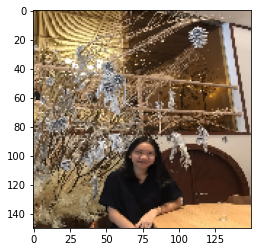

In [ ]:
# Mencoba model

from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  if classes[0,0]!=0:
    print('Orang ini berjenis kelamin perempuan')
  else:
    print('Orang ini berjenis kelamin laki-laki')

In [ ]:
# Membuat kolom baru di dataframe submission

submission['Jenis Kelamin'] = ''
submission.head()
path = '/content/drive/MyDrive/Data/Testing'
test_dir = os.path.join('/content', 'test')
if not os.path.exists(test_dir):
  os.makedirs(test_dir, exist_ok=True)

for img in os.listdir(path):
  shutil.copyfile(os.path.join(path, img), os.path.join(test_dir, img))
  try:
    impath = test_dir + '/' + img
    cropped_array = cropper.crop(impath)
    cropped_image = Image.fromarray(cropped_array)
    cropped_image.save(impath)
  except:
    pass

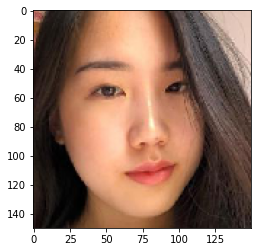

In [ ]:
# Memasukkan hasil prediksi

for files in os.listdir('/content/test'):
  path = '/content/test' + '/' + files
  img = image.load_img(path, target_size = (150, 150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  name = os.path.splitext(files)[0]
  if classes[0,0]==0:
    submission.loc[submission['id'] == name,'Jenis Kelamin'] = 0
  else:
    submission.loc[submission['id'] == name,'Jenis Kelamin'] = 1

In [ ]:
# Memeriksa dataset submission

submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             990 non-null    object
 1   Jenis Kelamin  990 non-null    object
dtypes: object(2)
memory usage: 15.6+ KB


                                       id Jenis Kelamin
700  b34e3594-f6ae-4d6f-9b36-183c339c3f2b             0


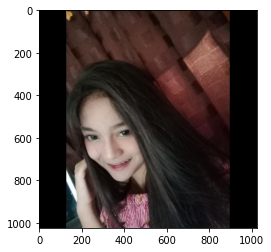

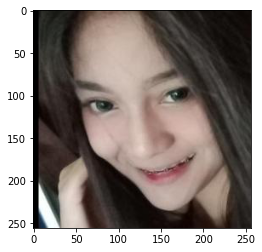

<Figure size 432x288 with 0 Axes>

In [ ]:
# Random Test

import random
path = random.choice(os.listdir('/content/drive/MyDrive/Data/Testing')) #change dir name to whatever
name = os.path.splitext(path)[0]
print(submission[submission['id'] == name])
im = Image.open('/content/drive/MyDrive/Data/Testing/' + path)
plt.imshow(im)
plt.show()
plt.clf()
im.close()

im = Image.open('/content/test/' + path)
plt.imshow(im)
plt.show()
plt.clf()
im.close()

In [ ]:
submission.head()

,id,Jenis Kelamin
0,005093b2-8c4b-4ed7-91c3-f5f4d50f8d27,1
1,0052554e-069e-4c43-beb0-0885e8f7684e,1
2,0092b954-1143-4a95-a17b-1edfa6af3b01,0
3,009fc28b-fe9b-441d-b8a2-ea8b7ae6ca16,0
4,00d0e306-06fe-45d8-ae6c-6f83ab8f7810,1


In [ ]:
submission.rename(columns={'id': 'id', 'Jenis Kelamin': 'jenis kelamin'}, inplace=True)

In [ ]:
submission.head()

,id,jenis kelamin
0,005093b2-8c4b-4ed7-91c3-f5f4d50f8d27,1
1,0052554e-069e-4c43-beb0-0885e8f7684e,1
2,0092b954-1143-4a95-a17b-1edfa6af3b01,0
3,009fc28b-fe9b-441d-b8a2-ea8b7ae6ca16,0
4,00d0e306-06fe-45d8-ae6c-6f83ab8f7810,1


In [ ]:
# Import Submission to csv

submission.to_csv('submission.csv', index = False)

from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>